# Описание проекта

Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании. Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года. В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

# Содержание работы:

1. Изучение данных
2. Предобработка данных
3. Исследовательский анализ данных
4. Портрет пользователя каждого региона
5. Проверка гипотез

## Изучение данных

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import math
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
games = pd.read_csv('/datasets/games.csv')
games.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [3]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Сразу бросается в глаза, что названия столбцов не приведены к нижнему регистру. При дальнейшей работе с данными это будет неудобно. Так же изучив данные, видно, что в столбцах 'year_of_release', 'critic_score' и 'user_score' некорректные типы данных, которые в дальнейшем следует изменить. 

## Предобработка данных

In [4]:
#Приведем названия столбцов к нижнему регистру.
games.columns = games.columns.str.lower()
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [5]:
#Приведем к числовому типу данных столбцы 'year_of_release', 'critic_score'
games['year_of_release'] = games['year_of_release'].astype('Int64')
games['critic_score'] = games['critic_score'].astype('Int64')

In [6]:
games.isna().sum()
#В name и genre всего по два пропуска:

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

In [7]:
games[games['name'].isnull()]
#Оказалась что пропуски у этих столбцов совпадают. Заполнить их как-либо нет возможности, поэтому их лучше отбросить.
games = games.dropna(subset=['name'])

In [8]:
#Пропусков в столбце 'year_of_release' не много. Заполнить их не предоставляется возможным, поэтому отбросим их
games = games.dropna(subset=['year_of_release'])

In [9]:
#Пропусков в столбцах critic_score и user_score очень много и заполнить их также не представляется возможным, как и удалить.
#Однако есть любопытные пропуски в user_score - 'tbd'.
#Абревиатура 'tbd' (to be defined) означает, что данные скоро будут обнародованы. Для нас это значение равнозначно пропуску
#Можно просто заменить на nan
#Приведем к вещественному типу данных столбец 'user_score'
games.loc[games['user_score'] == 'tbd', 'user_score'] = np.nan
games['user_score'] = games['user_score'].astype('float')

В столбце rating заменим все пропуски на 'unknown', т.е. рейтинг неизвестный. Так сможем учесть эти данные при дальнейшем анализе.

In [10]:
games['rating'] = games['rating'].fillna('unknown')
games.isna().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8461
user_score         8981
rating                0
dtype: int64

In [11]:
#Проверим наличие дубликатов
games.duplicated().sum()

0

In [12]:
#Добавим к исходной таблице столбец, в котором будет сумма продаж по всем регионам для каждой игры.
games['total_sales'] = games[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis = 1)
games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,<NA>,NaN,unknown,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,<NA>,NaN,unknown,31.38


Получилось много пропусков в столбцах critic_score, user_score. Можно предположить, что игры могут быть новыми, которые не успели оценить критики и пользователи. Эти данные нельзя просто так отбросить, потому что ещё могут пригодиться для дальнейшего анализа.

## Исследовательский анализ данных

In [13]:
# с помощью сводной таблицы сгруппируем данные по годам и посчитаем количество выпущенных игр для каждого года
year_games_count = games.pivot_table(index='year_of_release', aggfunc={'name':'count'})
year_games_count.columns = ['counts_of_games']
year_games_count

,counts_of_games
year_of_release,
1980,9
1981,46
1982,36
1983,17
1984,14
1985,14
1986,21
1987,16
1988,15


Text(0, 0.5, 'Количество игр')

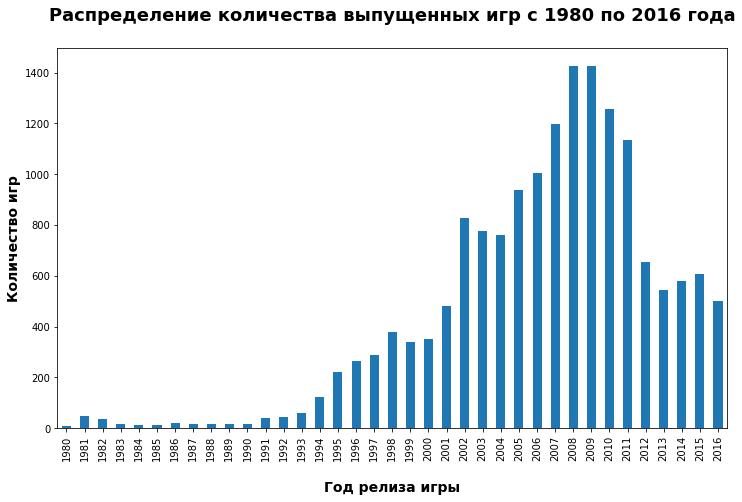

In [14]:
#построим график распределения количества выпущенных игр в течение интересующего нас отрезка времени
year_games_count.plot(y='counts_of_games', kind='bar', figsize=(12, 7), legend=False)
plt.title(label='Распределение количества выпущенных игр с 1980 по 2016 года\n', fontsize=18, fontweight="bold")
plt.xlabel("\nГод релиза игры", fontsize=14, fontweight="bold")
plt.ylabel("Количество игр", fontsize=14, fontweight="bold")

Видим что произошел скачок в разработке игр после 1993 года, так продолжалось до 2009 года, после чего пошел спад и резкое падение в разработке в 2012 году.

Для нашего анализа данные за весь предоставленный период не нужны, а нужны только те, которые отражают тенденции последних лет. В данном случае это данные после 2011 года.

In [15]:
#Определим десять платформ с наибольшими суммарными продажами
platform_sales_sum = (games
                      .pivot_table(index=['platform'], aggfunc={'total_sales':sum})
                      .nlargest(10, columns='total_sales')
                     )
platform_sales_sum

,total_sales
platform,
PS2,1233.56
X360,961.24
PS3,931.34
Wii,891.18
DS,802.78
PS,727.58
PS4,314.14
GBA,312.88
PSP,289.53


In [16]:
# создадим новый датафрэйм отфильтрованный по топ-10 платформ:
change_platform_years = games.query('platform in @platform_sales_sum.index')
change_platform_years

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E,82.54
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E,32.77
6,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89,8.5,E,29.80
7,Wii Play,Wii,2006,Misc,13.96,9.18,2.93,2.84,58,6.6,E,28.91
...,...,...,...,...,...,...,...,...,...,...,...,...
16708,Woody Woodpecker in Crazy Castle 5,GBA,2002,Platform,0.01,0.00,0.00,0.00,<NA>,NaN,unknown,0.01
16709,SCORE International Baja 1000: The Official Game,PS2,2008,Racing,0.00,0.00,0.00,0.00,<NA>,NaN,unknown,0.00
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,<NA>,NaN,unknown,0.01
16711,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,<NA>,NaN,unknown,0.01


In [17]:
# создаем список с временным диапазоном, доступным нам:
years_list = []
for i in range(1980, 2017):
    years_list.append(i)

In [18]:
# создаем список с названиями платформ:
platform_list = change_platform_years['platform'].unique()

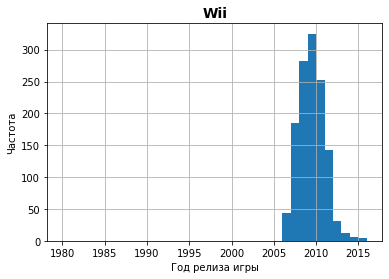

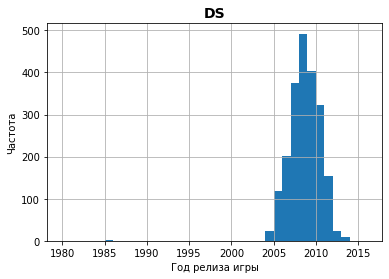

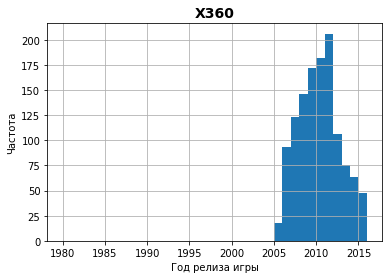

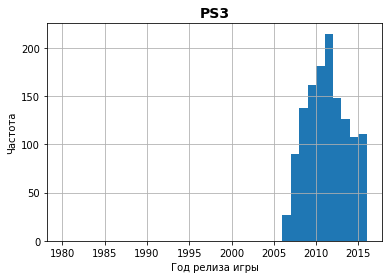

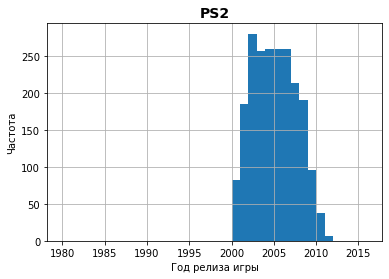

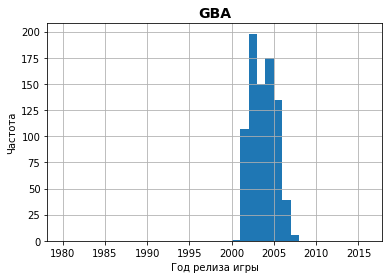

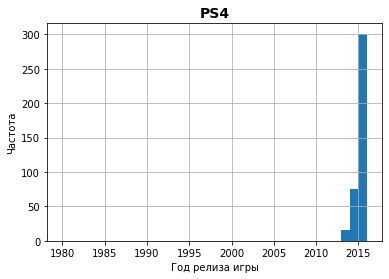

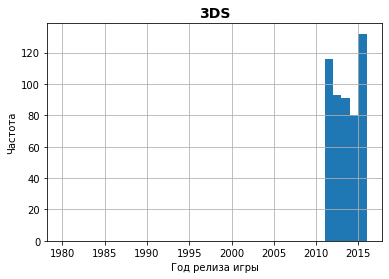

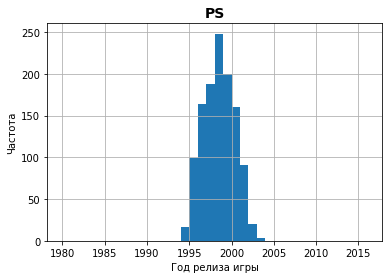

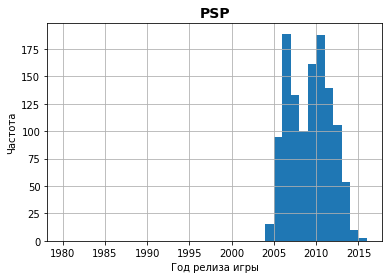

In [19]:
# цикл для построения гистограмм:

for j in range(0, len(platform_list)):
    change_platform_years[change_platform_years['platform']==platform_list[j]]\
    .plot(kind='hist', bins=years_list, legend=False, grid=True)
    
    plt.title(label=platform_list[j], fontsize=14, fontweight="bold")
    plt.xlabel("Год релиза игры")
    plt.ylabel("Частота")

Графики наглядно представляют поведение платформы за время ее существования, все ее взлеты и падения. Например, некоторые платформы, такие как PSP PS GBA и другие уже прекратили свое существование.

На всех консольных платформах наблюдался резкий скачок продаж в начале и конце существования.

Средний срок жизни платформы составляет 7 лет. Большинство платформ появляется в начале 2000-x, особенно в 2006 году

Для дальнейшего анализа выберем данные за последние несколько лет, т.к. они отражают последние тенденции и на их основании можно делать различные предположения о будущем поведении.

Актуальным периодом будем считать 2012 - 2016 года.

Сделаем срез данных по этому периоду.

In [20]:
relevant_years = []
for i in range(2012, 2017):
    relevant_years.append(i)

games_relevant = games.query('year_of_release in @relevant_years')
games_relevant

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97,8.2,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97,8.1,M,16.27
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,<NA>,NaN,unknown,14.63
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,<NA>,NaN,unknown,14.60
34,Call of Duty: Black Ops II,PS3,2012,Shooter,4.99,5.73,0.65,2.42,83,5.3,M,13.79
...,...,...,...,...,...,...,...,...,...,...,...,...
16703,Strawberry Nauts,PSV,2016,Adventure,0.00,0.00,0.01,0.00,<NA>,NaN,unknown,0.01
16707,Aiyoku no Eustia,PSV,2014,Misc,0.00,0.00,0.01,0.00,<NA>,NaN,unknown,0.01
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,<NA>,NaN,unknown,0.01
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,<NA>,NaN,unknown,0.01


Посмотрим какие платформы лидируют по суммарным продажам в этом периоде времени:

In [21]:
rel_platform_sales_sum = (games_relevant
                          .pivot_table(index='platform', values='total_sales', aggfunc=sum)
                          .sort_values(by='total_sales', ascending=False)
                         )
rel_platform_sales_sum

,total_sales
platform,
PS4,314.14
PS3,288.79
X360,236.54
3DS,194.61
XOne,159.32
WiiU,82.19
PC,62.65
PSV,49.18
Wii,35.37


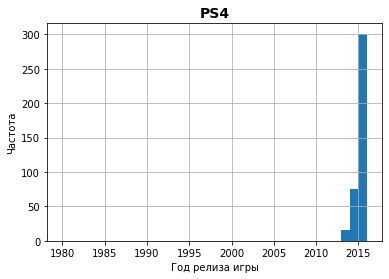

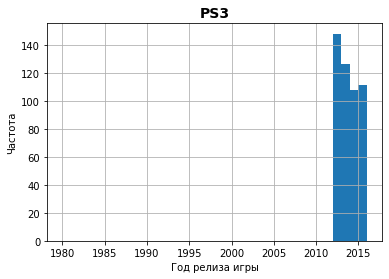

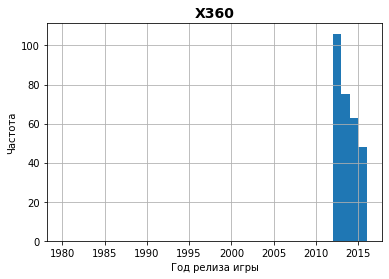

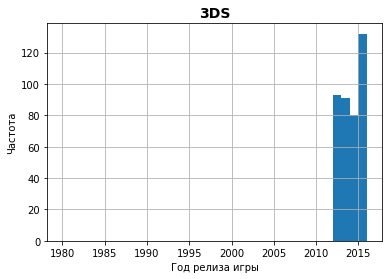

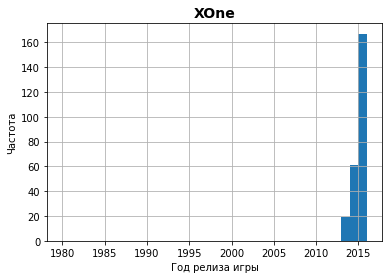

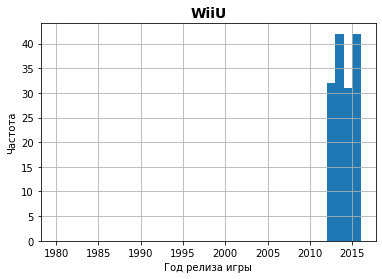

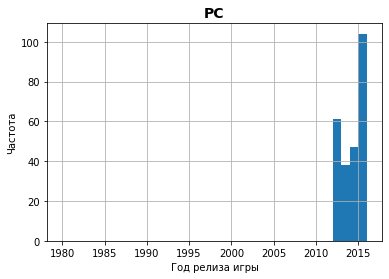

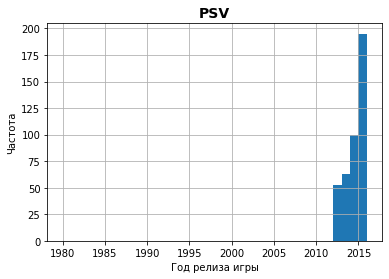

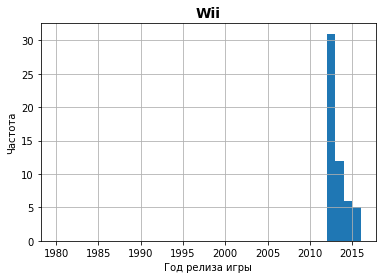

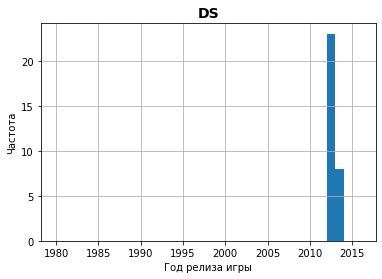

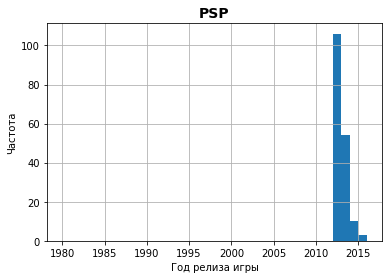

In [22]:
for j in range(0, len(rel_platform_sales_sum.index)):
    games_relevant[games_relevant['platform']==rel_platform_sales_sum.index[j]]\
    .plot(kind='hist', bins=years_list, legend=False, title=rel_platform_sales_sum.index[j], grid=True)
    
    plt.title(label=rel_platform_sales_sum.index[j], fontsize=14, fontweight="bold")
    plt.xlabel("Год релиза игры")
    plt.ylabel("Частота")

In [23]:
# посмотрим сколько было платформ в исходном датасете
len(games['platform'].unique())

31

В актуальном периоде, который мы выбрали, из 31 платформы остались только 11. Из этих 11 платформы DS и PSP можно исключить из потенциально прибыльных платформ, т.к. DS уже прекратила свое существование, а у PSP продажи практически равно нулю. Остальные же платформы можно включить в список потенциально прибыльных платформ

In [24]:
relevant_platforms = ['PS4', 'PS3', 'X360', '3DS', 'XOne', 'WiiU', 'PC', 'PSV', 'Wii']

(0.0, 2.5)

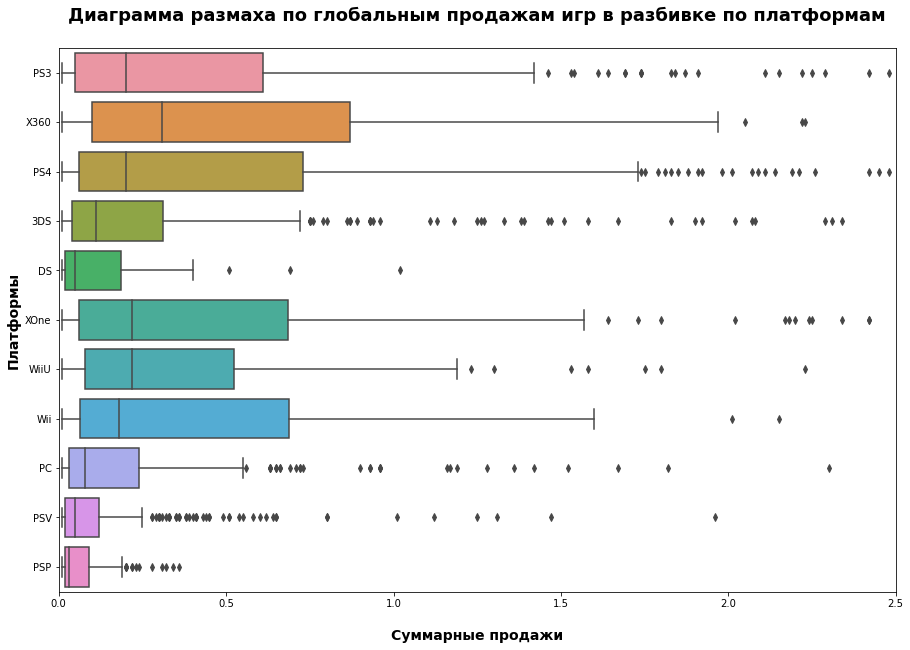

In [25]:
# построим все "ящики с усами" на одном графике для удобства
# используем библиотеку seaborn

plt.figure(figsize=(15,10))
sns.boxplot(data=games_relevant, x='total_sales', y='platform')

plt.title(label='Диаграмма размаха по глобальным продажам игр в разбивке по платформам\n', fontsize=18, fontweight="bold")
plt.xlabel("\nСуммарные продажи", fontsize=14, fontweight="bold")
plt.ylabel("Платформы", fontsize=14, fontweight="bold")
plt.xlim(0, 2.5)

По данным диаграммам легко определить была ли популярна платформа в интересующий нас отрезок времени. Определить можно по объему продаж, входящему в межквартильный размах и медианному значению, чем они выше тем популярнее платформа. Например PS4 или X360 несомненно популярны.

Выберем несколько популярных и потенциально прибыльных платформ и посмотрим как продажи на этих платформах зависят от оценок игр.

In [26]:
X360 = games_relevant.query('platform == "X360"')
X360_cor = X360[['critic_score','user_score', 'total_sales']]
X360_cor.corr()

,critic_score,user_score,total_sales
critic_score,1.000000,0.557352,0.360573
user_score,0.557352,1.000000,0.006164
total_sales,0.360573,0.006164,1.000000


Text(0, 0.5, 'Продажи')

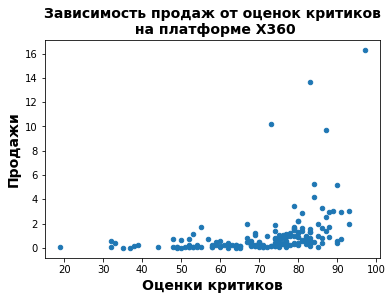

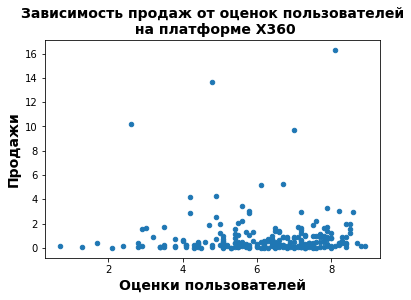

In [27]:
X360_cor.plot(x='critic_score', y='total_sales', kind='scatter', title='X360');
plt.title(label='Зависимость продаж от оценок критиков\n на платформе X360', fontsize=14, fontweight="bold")
plt.xlabel("Оценки критиков", fontsize=14, fontweight="bold")
plt.ylabel("Продажи", fontsize=14, fontweight="bold")

X360_cor.plot(x='user_score', y='total_sales', kind='scatter', title='X360');
plt.title(label='Зависимость продаж от оценок пользователей\n на платформе X360', fontsize=14, fontweight="bold")
plt.xlabel("Оценки пользователей", fontsize=14, fontweight="bold")
plt.ylabel("Продажи", fontsize=14, fontweight="bold")

In [28]:
PS4 = games_relevant.query('platform == "PS4"')
PS4_cor = PS4[['critic_score','user_score', 'total_sales']]
PS4_cor.corr()

,critic_score,user_score,total_sales
critic_score,1.000000,0.557654,0.406568
user_score,0.557654,1.000000,-0.031957
total_sales,0.406568,-0.031957,1.000000


Text(0, 0.5, 'Продажи')

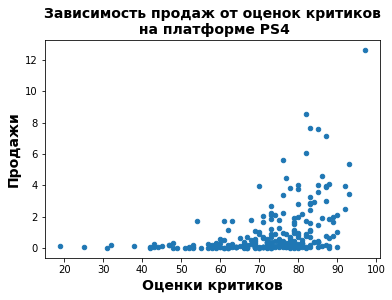

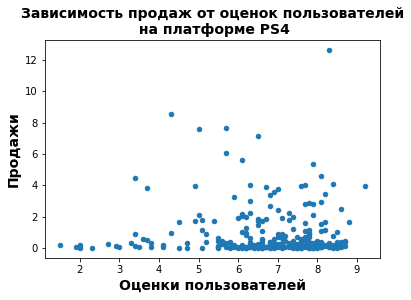

In [29]:
PS4_cor.plot(x='critic_score', y='total_sales', kind='scatter', title='PS4');
plt.title(label='Зависимость продаж от оценок критиков\n на платформе PS4', fontsize=14, fontweight="bold")
plt.xlabel("Оценки критиков", fontsize=14, fontweight="bold")
plt.ylabel("Продажи", fontsize=14, fontweight="bold")

PS4_cor.plot(x='user_score', y='total_sales', kind='scatter', title='PS4');
plt.title(label='Зависимость продаж от оценок пользователей\n на платформе PS4', fontsize=14, fontweight="bold")
plt.xlabel("Оценки пользователей", fontsize=14, fontweight="bold")
plt.ylabel("Продажи", fontsize=14, fontweight="bold")

In [30]:
XOne = games_relevant.query('platform == "XOne"')
XOne_cor = XOne[['critic_score','user_score', 'total_sales']]
XOne_cor.corr()

,critic_score,user_score,total_sales
critic_score,1.000000,0.472462,0.416998
user_score,0.472462,1.000000,-0.068925
total_sales,0.416998,-0.068925,1.000000


Text(0, 0.5, 'Продажи')

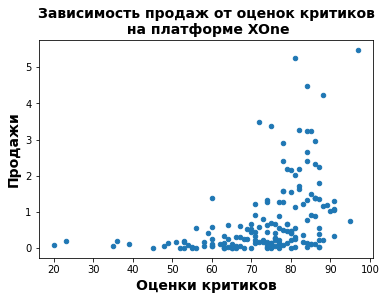

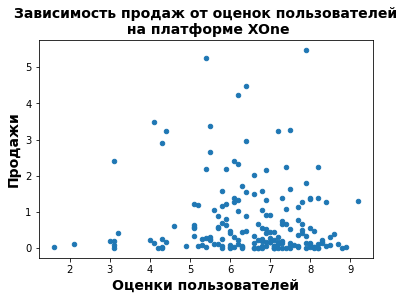

In [31]:
XOne_cor.plot(x='critic_score', y='total_sales', kind='scatter', title='XOne');
plt.title(label='Зависимость продаж от оценок критиков\n на платформе XOne', fontsize=14, fontweight="bold")
plt.xlabel("Оценки критиков", fontsize=14, fontweight="bold")
plt.ylabel("Продажи", fontsize=14, fontweight="bold")

XOne_cor.plot(x='user_score', y='total_sales', kind='scatter', title='XOne');
plt.title(label='Зависимость продаж от оценок пользователей\n на платформе XOne', fontsize=14, fontweight="bold")
plt.xlabel("Оценки пользователей", fontsize=14, fontweight="bold")
plt.ylabel("Продажи", fontsize=14, fontweight="bold")

In [32]:
PS3 = games_relevant.query('platform == "PS3"')
PS3_cor = XOne[['critic_score','user_score', 'total_sales']]
PS3_cor.corr()

,critic_score,user_score,total_sales
critic_score,1.000000,0.472462,0.416998
user_score,0.472462,1.000000,-0.068925
total_sales,0.416998,-0.068925,1.000000


Text(0, 0.5, 'Продажи')

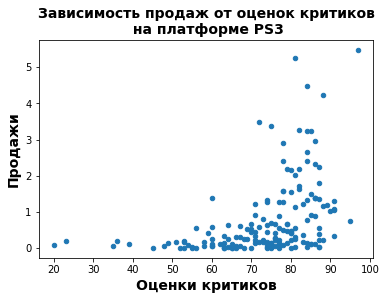

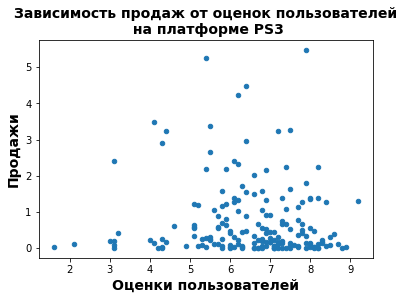

In [33]:
PS3_cor.plot(x='critic_score', y='total_sales', kind='scatter', title='PS3');
plt.title(label='Зависимость продаж от оценок критиков\n на платформе PS3', fontsize=14, fontweight="bold")
plt.xlabel("Оценки критиков", fontsize=14, fontweight="bold")
plt.ylabel("Продажи", fontsize=14, fontweight="bold")

PS3_cor.plot(x='user_score', y='total_sales', kind='scatter', title='PS3');
plt.title(label='Зависимость продаж от оценок пользователей\n на платформе PS3', fontsize=14, fontweight="bold")
plt.xlabel("Оценки пользователей", fontsize=14, fontweight="bold")
plt.ylabel("Продажи", fontsize=14, fontweight="bold")

Исходя из графиков рассеяния можно сказать, что объем продаж довольно резко возрастает при оценке критиков от 60 и выше, до этой отметки продажи малы.
Зависимость продаж от оценок пользователей менее выраженная, но можно сказать, что продажи растут начиная с отметок в 2-4 балла

В целом коэффициент корреляции показывает, что зависимость продаж от оценок критиков сильнее, чем от оценок пользователей.

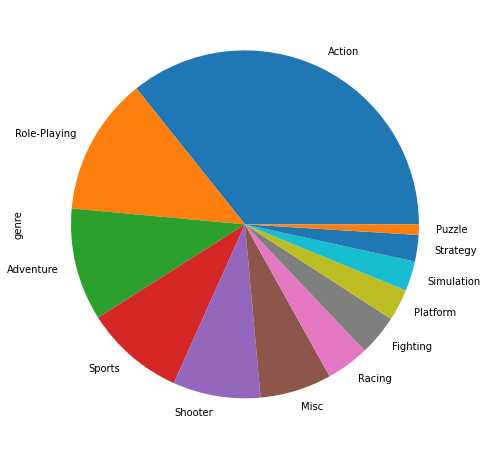

In [34]:
#Посмотрим на общее распределение игр по жанрам
games_relevant['genre'].value_counts().plot(kind='pie', figsize=(8, 8), legend=False);

Жанр Action лидирует с отрывом, далее идут игры ролевые, приключения, спортивные и стрелялки. Наименьшее количество игр в жанре Puzzle (довольно специфичный вид игры, который не всем нравится).

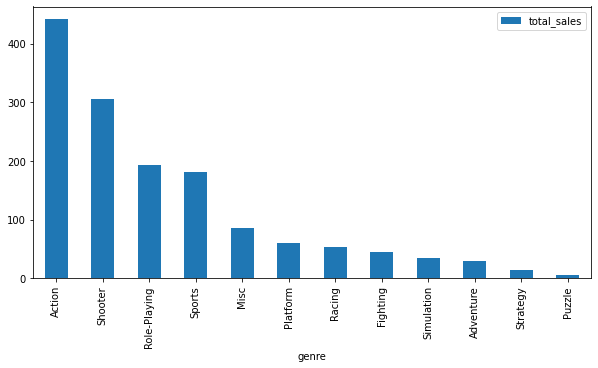

In [35]:
#Посмотрим как распределяются продажи в зависимости от жанра игры:
(games_relevant
                   .pivot_table(index='genre', aggfunc={'total_sales':sum})
                   .sort_values(by='total_sales', ascending=False)
                   .plot(y='total_sales', kind='bar', figsize=(10, 5))
);

В целом похожая картина. Жанр Action лидирует в продажах, далее шутеры, ролевые и спортивные. Однако игры жанра Adventure на этот раз в конце списка. Несмотря на то, что производят их довольно много продаются они крайне плохо по сравнение с остальными топовыми жанрами. Жанр Puzzle замыкает список.

(0.0, 2.5)

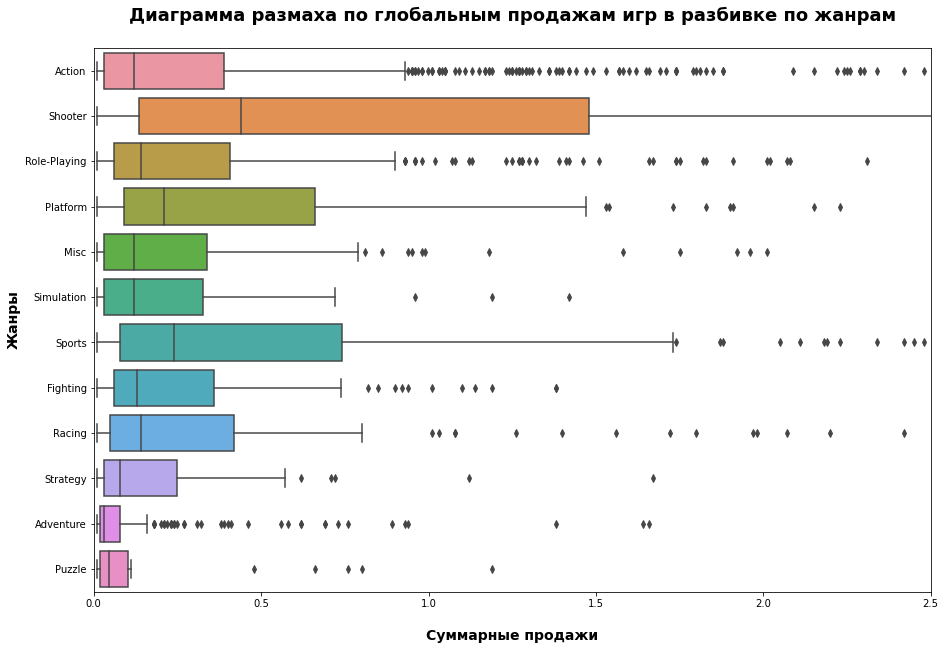

In [36]:
plt.figure(figsize=(15,10))
sns.boxplot(data=games_relevant, x='total_sales', y='genre')

plt.title(label='Диаграмма размаха по глобальным продажам игр в разбивке по жанрам\n', fontsize=18, fontweight="bold")
plt.xlabel("\nСуммарные продажи", fontsize=14, fontweight="bold")
plt.ylabel("Жанры", fontsize=14, fontweight="bold")
plt.xlim(0, 2.5)

Построив график "ящик с усами" в разбивке по жанрам можно заметить сильное различие. Лидерства жанра Action как и не было. Здесь с большим отрывом лидирует жанр "Shooter", так же хорошие показатели показывают жанры "Sports", "Platform", "Racing" и "Role-Playing". И только после этих жанров идет лидириющещй при анализе ранее "Action".

## Портрет пользователя каждого региона

In [37]:
top5_platforms_per_region = (games_relevant
        .pivot_table(index='platform', aggfunc={'na_sales':sum, 'eu_sales':sum, 'jp_sales':sum})
       )
   
top5_platforms_per_region

,eu_sales,jp_sales,na_sales
platform,,,
3DS,42.64,87.79,55.31
DS,3.53,3.72,4.59
PC,37.76,0.00,19.12
PS3,106.86,35.29,103.38
PS4,141.09,15.96,108.74
PSP,0.42,10.47,0.13
PSV,11.36,21.04,10.98
Wii,11.92,3.39,17.45
WiiU,25.13,13.01,38.10


Построим графики распределения продаж по платформам оставив самые популярные:

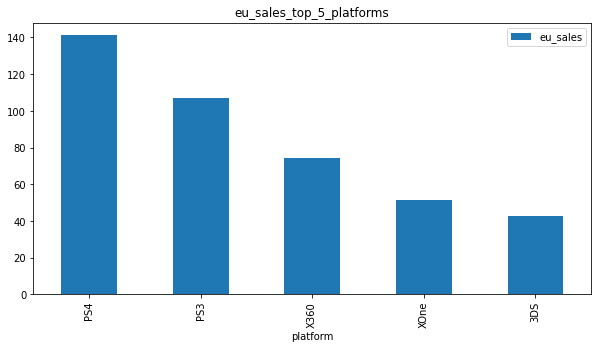

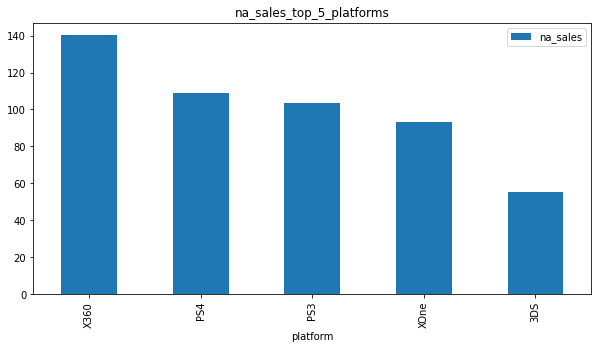

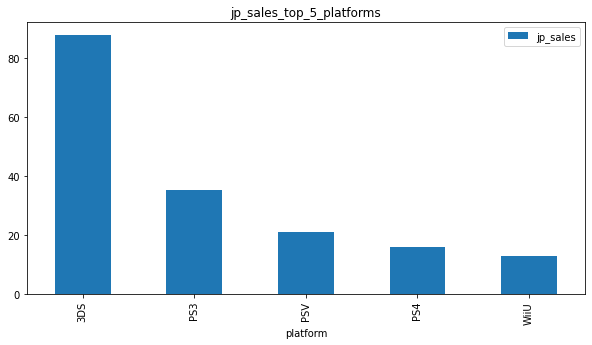

In [38]:
# список регионов для цикла
region = ['eu_sales', 'na_sales', 'jp_sales']

for i in range(0, 3):
    (top5_platforms_per_region
     .nlargest(5, columns=region[i])
     .plot(y=region[i], kind='bar', figsize=(10, 5), title=region[i]+'_top_5_platforms')
    )

В Европе самая популярная платформа PS4, в Северной Америке X360, в Японии - Nintendo 3DS. Американцы и японцы поддерживают своих производителей.

Для каждого региона посчитаем суммарные продажи по жанрам и определим 5 самых популярных.

In [39]:
top5_genre_per_region = (games_relevant
        .pivot_table(index='genre', aggfunc={'na_sales':sum, 'eu_sales':sum, 'jp_sales':sum})
       )
   
top5_genre_per_region

,eu_sales,jp_sales,na_sales
genre,,,
Action,159.34,52.80,177.84
Adventure,9.46,8.24,8.92
Fighting,10.79,9.44,19.79
Misc,26.32,12.86,38.19
Platform,21.41,8.63,25.38
Puzzle,1.40,2.14,1.13
Racing,27.29,2.50,17.22
Role-Playing,48.53,65.44,64.00
Shooter,113.47,9.23,144.77


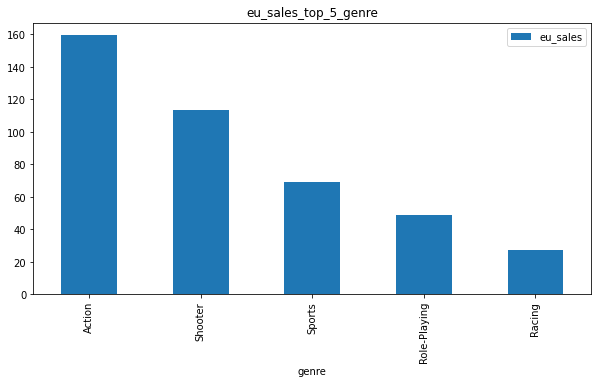

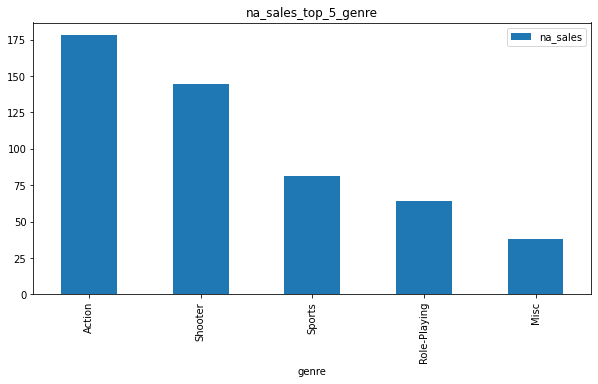

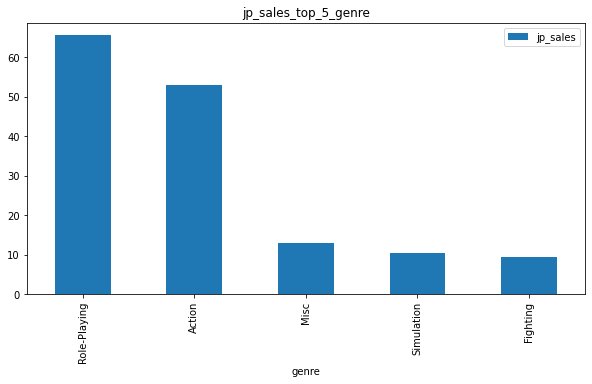

In [40]:
for i in range(0, 3):
    (top5_genre_per_region
     .nlargest(5, columns=region[i])
     .plot(y=region[i], kind='bar', figsize=(10, 5), title=region[i]+'_top_5_genre')
    )

Пользователи Европы и Северной Америки практически идентичны, за исключением последнего жанра: в Европе это гонки, а в Северной Америке - аркады. Пользователи Японии как ввсегда особенные, предпочитают ролевые игры, но также разделяют любовь жителей запада к жанру Action. В Японии жанры Role и Action лидеры в продажах с большим и резким отрывом от остальных жанров.

Пользователи Европы и Северной Америки играют в целом в одни и те же консоли и игровая индустрия больше развита в игре из дома, поэтому популярны жанры - Action, Sports, Shooter. В Японии преобладают пользователи с портативными консолями, в которые можно играть не только дома, поэтому они предпочитают жанр - Role-Playing и редко играют в игры с жанром - Shooter.

In [41]:
#Влияние рейтинга ESRB на продажи в каждом отдельном регионе
rating_sum = games_relevant.pivot_table(index='rating', aggfunc={'na_sales':sum, 'eu_sales':sum, 'jp_sales':sum})
rating_sum

,eu_sales,jp_sales,na_sales
rating,,,
E,113.03,28.33,114.37
E10+,55.37,8.19,75.70
M,193.96,21.20,231.57
T,52.96,26.02,66.02
unknown,91.50,108.84,103.31


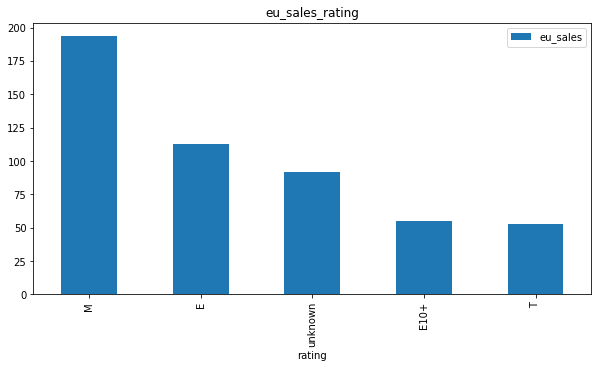

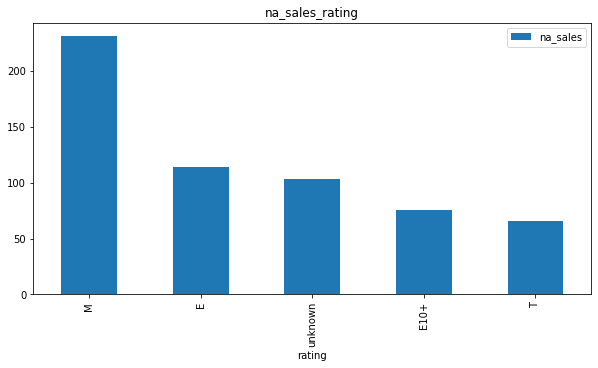

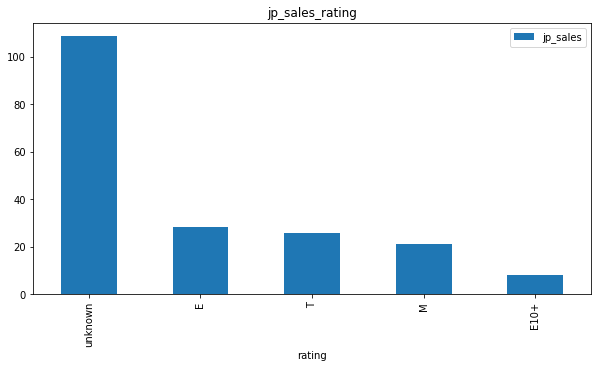

In [42]:
for i in range(0, 3):
    (rating_sum
     .sort_values(by=region[i], ascending=False)
     .plot(y=region[i], kind='bar', figsize=(10, 5), title=region[i]+'_rating')
    )

В Америке и Европе идентичное распределение продаж в зависимости от рейтингов: преобладают, с большим отрывом, игры для взрослых, далее игры для всех, на третьем месте игры с неизвестным рейтингом и замыкают игры 13+.

В Японии все опять не так: лидируют игры с неизвестным рейтингом с большим отрывом, меньше всего популярны игры 10+.

В целом можно сказать, что американцы и европейцы схожи в выборе платформ, жанров и возрастного рейтинга игр. Т.е. портреты пользователей идентичны.
Японцы сильно отличаются в предпочтениях от западных игроков. Я думаю это связанно с тем, что Япония страна консервативная в плане традиций и культуры, в стране меньшее количество иммигрантов, чем в остальных областях планеты. Поэтому так хорошо и четко просматриваются различия в предпочтениях.


## Проверка гипотез

#Гипотеза 1:
#Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

#Сформулируем нулевую и альтернативную гипотезы:

#H0 - средние пользовательские рейтинги платформ Xbox One и PC равны (в H0 всегда используется знак равенства);

#H1 - средний пользовательский рейтинг платформы Xbox One отличается от среднего пользовательского рейтинга платформы PC.



In [43]:
XOne = games_relevant[(games_relevant['platform'] == 'XOne') &  (games_relevant['user_score'] > 0)]['user_score']
PC = games_relevant[(games_relevant['platform'] == 'PC') &  (games_relevant['user_score'] > 0)]['user_score']
print('Средний пользовательский рейтинг платформы Xbox One:', XOne.mean())
print('Средний пользовательский рейтинг платформы PC', PC.mean())

Средний пользовательский рейтинг платформы Xbox One: 6.521428571428572
Средний пользовательский рейтинг платформы PC 6.4286407766990274


In [44]:
#проверяем первую гипотезу

alpha = .05

results = st.ttest_ind(XOne, PC, equal_var=False)

print('p-значение:', results.pvalue)


if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5489537965134912
Не получилось отвергнуть нулевую гипотезу


Вывод: 1 гипотеза подтвердилась. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

#Гипотеза 2: #Cредние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

#Сформулируем нулевую и альтернативную гипотезы:

#H0 - средние пользовательские рейтинги жанров Action и Sports равны (в H0 всегда используется знак равенства);

#H1 - средние пользовательские рейтинги жанров Action и Sports различаются.

In [45]:
Action = games_relevant[(games_relevant['genre'] == 'Action') &  (games_relevant['user_score'] > 0)]['user_score']
Sports = games_relevant[(games_relevant['genre'] == 'Sports') &  (games_relevant['user_score'] > 0)]['user_score']
print('Средний пользовательский рейтинг жанра Action:', Action.mean())
print('Средний пользовательский рейтинг жанра Sports', Sports.mean())

Средний пользовательский рейтинг жанра Action: 6.825047801147227
Средний пользовательский рейтинг жанра Sports 5.455897435897437


In [46]:
#проверяем вторую гипотезу

alpha = .05

results = st.ttest_ind(Action, Sports, equal_var=False)

print('p-значение:', results.pvalue)


if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 4.24307776572644e-20
Отвергаем нулевую гипотезу


Вывод: 2 гипотеза подтвердилась. Средние пользовательские рейтинги жанров Action и Sports разные

## Напишите общий вывод

Критерии определяющие успешность игры:

1.Регион

 - Рейтинг ассоциации, определяющей возрастной рейтинг компьютерных игр

 - Платформа, которая наиболее распространена в данном регионе

 - Жанр

2.Рейтинг критиков (влияет на количество продаж во всех регионах)

 - Игры, которые будут продаваться в Северной Америке лучше всего:

ESRB: M, E, Unknown

Платформ(в порядке убывания): Xbox360, PS4, PS3, XOne, 3DS

Жанры: Action, Sports, Shooter, Role-Playing, Misc


 - Игры, которые будут продаваться в Европе лучше всего:

ESRB: M, E, Unknown

Платформы: в PS4, PS3, Xbox360, XOne, 3DS

Жанры: Action, Sports, Shooter, Role-Playing, Racing


 - Игры, которые будут продаваться в Японии лучше всего:

ESRB: Unknown, E, T

Платформы: 3DS, PS3, PSV, PS4, Wii

Жанры: Role-Playing, Action, Misc, Sumulation, Fighting